              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1198
           1       0.99      0.99      0.99       910

    accuracy                           0.99      2108
   macro avg       0.99      0.99      0.99      2108
weighted avg       0.99      0.99      0.99      2108



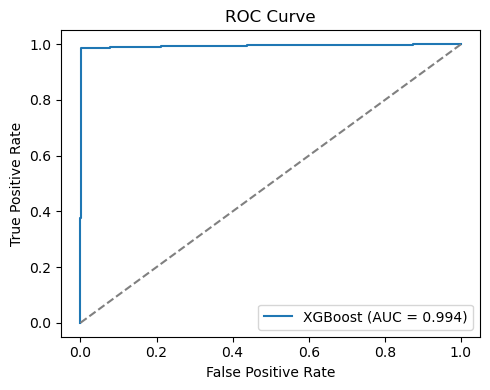

C:\Users\19078\AppData\Local\Temp\ipykernel_6032\1016321983.py:111: UserWarning: [10:25:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  score_dict   = booster.get_score(importance_type="gain")


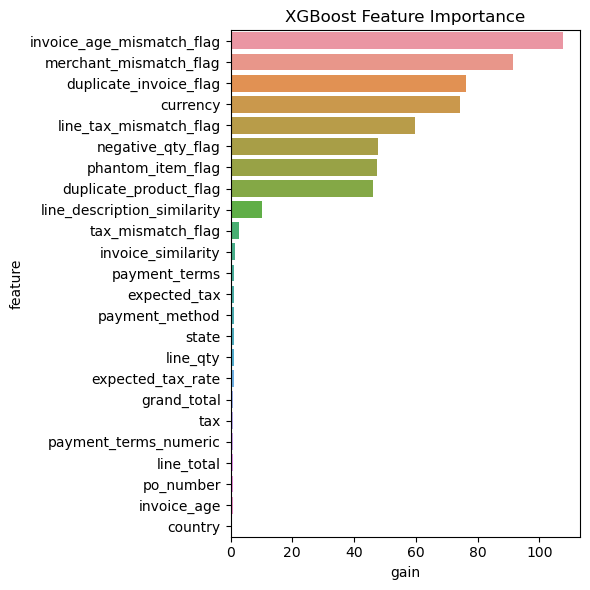

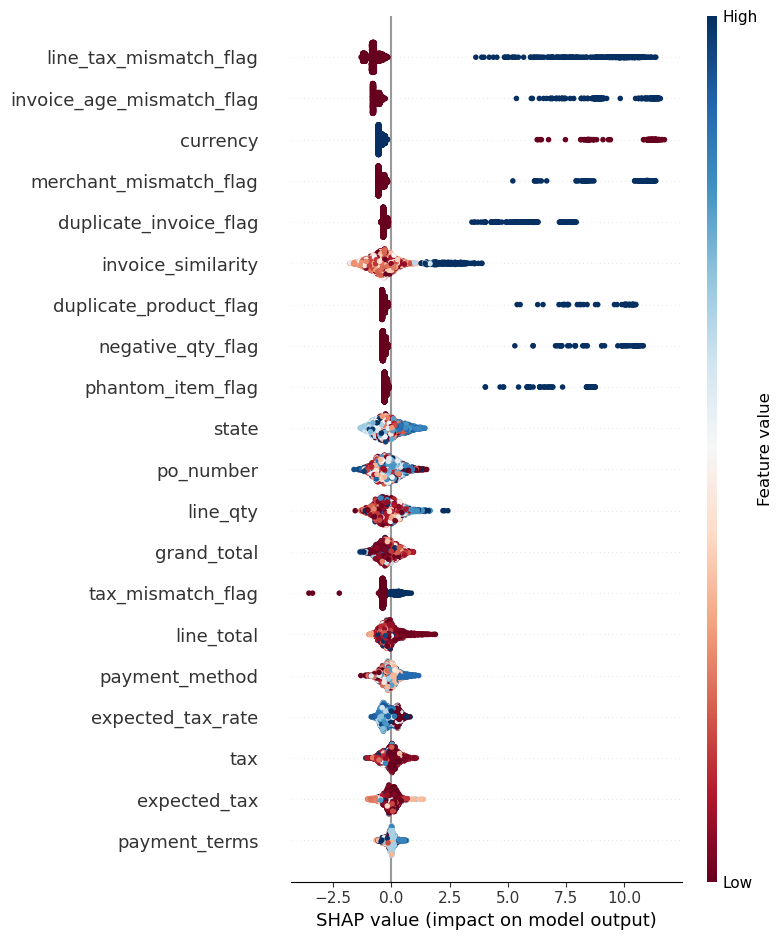

<Figure size 640x480 with 0 Axes>

In [2]:
# ------------------------------------------------------------------ #
# --- Model Train -------------------------------------------------- #
# ------------------------------------------------------------------ #
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)

"""
This module builds and runs an XGBoost model to predict which 
invoices are anomalous. The input is a parquet file, which is the output from 
preprocess.py, containing invoice data after feature engineering preprocessing.

The output is...

"""


from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from collections import Counter
import pandas as pd

# Load data
df_train = pd.read_parquet('train_df.parquet', engine='pyarrow')
df_test = pd.read_parquet('test_df.parquet', engine='pyarrow')

# Separate features X and target y (anomaly label 0 or 1)
X_train = df_train.drop(['is_anomalous', '_ANOMALY_TYPES_DROP_BEFORE_TRAINING_'], axis=1)
y_train = df_train['is_anomalous']
X_test = df_test.drop(['is_anomalous', '_ANOMALY_TYPES_DROP_BEFORE_TRAINING_'], axis=1)
y_test = df_test['is_anomalous']

# use label encoding for categorical/name columns (po_number, payment_method, country, state, and currency)
# label encoding is fine because tree-based models don’t assume ordering in the numbers

# remove merchant, merchant chain, merchant branch, and merchant address
# remove datetime cols, only use important info (time between invoice date and due: invoice_age)
X_train = X_train.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])
X_test = X_test.drop(columns=['merchant', 'merchant_branch', 'merchant_chain', 'merchant_address', 'invoice_date', 'due_date'])

# Identify categorical columns
col_types = dict(X_train.dtypes)
label_cols = [col for col, dtype in col_types.items() if dtype == 'object']

# Label encode each categorical column (keeping consistency between train and test)
encoders = {}
for col in label_cols:
    encoder = LabelEncoder()
    combined = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
    encoder.fit(combined)
    X_train[col] = encoder.transform(X_train[col].astype(str))
    X_test[col] = encoder.transform(X_test[col].astype(str))
    encoders[col] = encoder  # Optional: store encoders for inverse_transform or future use


# model for the best set of hyper-paramters

model = XGBClassifier(
    scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1]),
    colsample_bytree=0.8,
    learning_rate=0.3,
    max_depth=5,
    subsample=1,
    n_estimators=200,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# adjust the threshold for is_anomaly
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.4).astype(int)  # lower threshold = higher recall

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresh))


# ------------------------------------------------------------------ #
# --- 1) ROC curve + AUC ------------------------------------------- #
# ------------------------------------------------------------------ #
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------ #
# --- 2) Feature importance (gain) --------------------------------- #
# ------------------------------------------------------------------ #
# Version 1 – use built‑in importance (gain)
booster      = model.get_booster()
booster.set_param({"predictor": "cpu_predictor"})  # silence GPU warning, if any
score_dict   = booster.get_score(importance_type="gain")
# Any feature absent in score_dict has zero gain → add them
gain_df = (
    pd.DataFrame({
        "feature": X_train.columns,
        "gain": [score_dict.get(f, 0.0) for f in X_train.columns]
    })
    .sort_values("gain", ascending=False)
)

plt.figure(figsize=(6, 6))
sns.barplot(data=gain_df, x="gain", y="feature", orient="h")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------ #
# --- 3) SHAP summary plot (class 1) --------------------------------#
# ------------------------------------------------------------------ #
explainer   = shap.TreeExplainer(model)     # trained XGBClassifier
shap_vals   = explainer.shap_values(X_test) # list for binary

if isinstance(shap_vals, list) and len(shap_vals) == 2:
    shap_vals = shap_vals[1]                # class‑1 SHAPs

mean_abs  = np.abs(shap_vals).mean(axis=0)  # one value per feature
order     = np.argsort(-mean_abs)           # descending indices

# Re‑order SHAP matrix and feature columns
shap_sorted = shap_vals[:, order]
X_sorted    = X_test.iloc[:, order]         # pandas keeps column names

sorted_names = X_sorted.columns.tolist()    # optional, explicit names

shap.summary_plot(
    shap_sorted,
    X_sorted,
    feature_names=sorted_names,
    plot_type="dot",
    cmap="RdBu",          # blue ↔ red
    color_bar=True,
    show=True
)

plt.tight_layout()
plt.show()

